In [1]:
import numpy as np
import pandas as pd
nhanes_HBV = pd.read_csv('nhanes_HBV (1).csv', index_col=None)

In [2]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier, RUSBoostClassifier, EasyEnsembleClassifier
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from imblearn.under_sampling import TomekLinks, RandomUnderSampler, NearMiss, ClusterCentroids
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, roc_auc_score, recall_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, roc_curve, precision_recall_curve
import pickle
sns.set()

In [4]:
#Proportion of infections
nhanes_HBV[(nhanes_HBV['resp_2']=='HBV Infection')].shape[0]*100.0/(nhanes_HBV.shape[0])

0.8265891955454105

# Exploratory Data Analysis

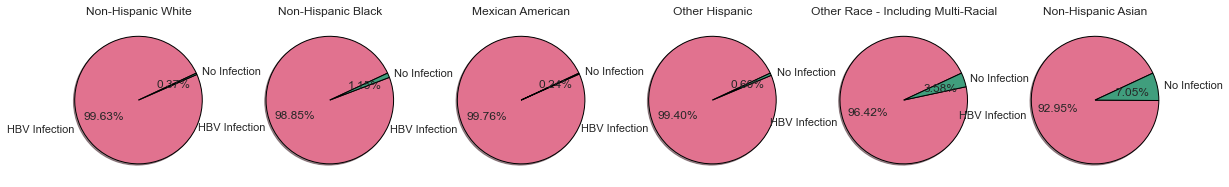

In [5]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,6, figsize=[20,5])
axes.flatten()
j=0
colors = ['#E1728F', '#409E7D'] 
for i in ['Non-Hispanic White', 'Non-Hispanic Black', 'Mexican American','Other Hispanic', 'Other Race - Including Multi-Racial','Non-Hispanic Asian']:
    nhanes_race_type = nhanes_HBV[nhanes_HBV['Race_Ethnicity'] == i]
    axes[j].pie(nhanes_race_type['resp_2'].value_counts(), labels=['HBV Infection', 'No Infection'],
                autopct='%1.2f%%', wedgeprops={'edgecolor': 'black'}, shadow=True, startangle=25,
                colors=colors)
    axes[j].set_title(i)
    j+=1

In [6]:
# One-hot encode categorical columns
cat_columns = ['Gender','Race_Ethnicity','Veteran_Status','Country_of_birth','Citizenship_status','Education_level','Marital_status','Health_care_1_year','liver_condition','Blood_Transfusion','Hepatitis_C']
nhanes_HBV_encoded = pd.get_dummies(nhanes_HBV, columns=cat_columns)

In [7]:
nhanes_HBV_encoded

,Respondent_sequence_number,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,resp_2,Data_release_cycle,Age,Two_year_interview_weight,Two_year_MEC_weight,...,liver_condition_Don't know,liver_condition_No,liver_condition_Yes,Blood_Transfusion_Don't know,Blood_Transfusion_No,Blood_Transfusion_Refused,Blood_Transfusion_Yes,Hepatitis_C_Don't know,Hepatitis_C_No,Hepatitis_C_Yes
0,9966,Negative,Negative,Negative,No Doses,No Infection,2,39,85045.16006,9.135299e+04,...,0,1,0,0,1,0,0,0,1,0
1,9967,Negative,Negative,Negative,No Doses,No Infection,2,23,29465.45681,2.945668e+04,...,0,1,0,0,1,0,0,0,1,0
2,9968,Negative,Negative,Negative,No Doses,No Infection,2,84,20658.10938,2.750814e+04,...,0,1,0,0,1,0,0,0,1,0
3,9969,Negative,Negative,Negative,No Doses,No Infection,2,51,75077.43159,7.853632e+04,...,0,1,0,0,1,0,0,0,1,0
4,9972,Negative,Negative,Negative,No Doses,No Infection,2,44,93545.00186,9.355893e+04,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28909,102943,Negative,Missing,Negative,No Doses,No Infection,10,48,27858.07943,2.951982e+04,...,0,0,1,0,1,0,0,0,1,0
28910,102947,Negative,Missing,Negative,No Doses,No Infection,10,75,13379.65072,1.356396e+04,...,0,1,0,0,0,0,1,0,1,0
28911,102949,Negative,Missing,Negative,No Doses,No Infection,10,33,29334.65020,3.028719e+04,...,0,1,0,0,1,0,0,0,1,0
28912,102950,Missing,Missing,Missing,No Doses,No Infection,10,64,11804.99350,5.400000e-79,...,0,1,0,0,1,0,0,0,1,0


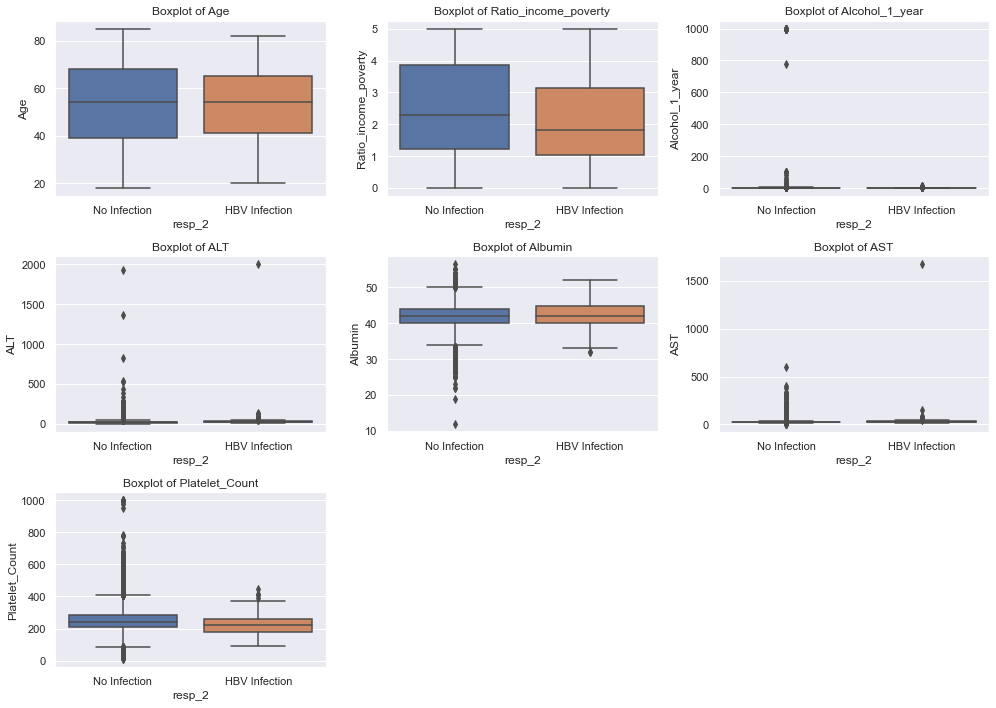

In [8]:
continuous_columns = ['Age','Ratio_income_poverty','Alcohol_1_year','ALT','Albumin','AST','Platelet_Count']

# Create a new DataFrame for each response variable value
df_0 = nhanes_HBV[nhanes_HBV['resp_2'] == "HBV Infection"]
df_1 = nhanes_HBV[nhanes_HBV['resp_2'] == "No Infection"]

# Create separate boxplots for each continuous column
plt.figure(figsize=(14, 10))

for col in continuous_columns:
    plt.subplot(3, 3, continuous_columns.index(col) + 1)
    sns.boxplot(x=nhanes_HBV['resp_2'], y=col, data=nhanes_HBV, showfliers=True)
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

In [9]:
# Function to remove outliers using IQR method
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Remove outliers for each continuous variable
for column in continuous_columns:
    nhanes_HBV_outliers = remove_outliers_iqr(nhanes_HBV, column)

# Display the DataFrame after removing outliers
nhanes_HBV_outliers[nhanes_HBV_outliers['resp_2']=='HBV Infection']

,Respondent_sequence_number,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,resp_2,Data_release_cycle,Gender,Age,Race_Ethnicity,...,Alcohol_1_year,Health_care_1_year,liver_condition,Blood_Transfusion,Hepatitis_C,ALT,Albumin,AST,Platelet_Count,concat
256,10775,Positive,Positive,Negative,No Doses,HBV Infection,2,Female,77,Non-Hispanic Black,...,1.818369,10 to 12,No,Yes,No,15.000,41.00000,20.000,255.0,16.0_2.0
371,11168,Positive,Positive,Negative,No Doses,HBV Infection,2,male,40,Other Race - Including Multi-Racial,...,1.818369,0,Yes,No,No,26.000,46.00000,22.000,254.0,15.0_1.0
1106,13655,Positive,Positive,Negative,Don't know,HBV Infection,2,male,49,Non-Hispanic Black,...,3.000000,2 to 3,No,No,Yes,24.000,42.00000,25.000,218.0,20.0_2.0
1416,14649,Positive,Positive,Positive,Don't know,HBV Infection,2,male,49,Non-Hispanic Black,...,1.818369,0,No,No,No,22.000,42.00000,20.000,310.0,20.0_1.0
1604,15193,Positive,Positive,Negative,No Doses,HBV Infection,2,male,50,Other Race - Including Multi-Racial,...,5.000000,0,No,No,No,34.000,47.00000,34.000,304.0,26.0_2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28362,101362,Negative,Missing,Negative,No Doses,HBV Infection,10,Female,74,Non-Hispanic White,...,2.104279,4 to 9,No,No,No,20.922,40.72728,33.284,207.0,140.0_1.0
28365,101375,Positive,Positive,Missing,No Doses,HBV Infection,10,male,53,Non-Hispanic Asian,...,2.104279,0,No,No,No,29.026,40.72728,22.086,120.0,148.0_1.0
28616,102103,Positive,Positive,Negative,No Doses,HBV Infection,10,male,37,Other Race - Including Multi-Racial,...,2.104279,4 to 9,Yes,No,No,18.896,44.90328,20.050,250.0,136.0_1.0
28799,102635,Positive,Positive,Negative,Don't know,HBV Infection,10,Female,40,Non-Hispanic Asian,...,2.104279,2 to 3,Yes,Yes,No,19.909,39.68328,26.158,160.0,134.0_1.0


In [10]:
nhanes_HBV_outliers.dtypes

Respondent_sequence_number      int64
Core_Antibody                  object
Surface_Antigen                object
Surface_Antibody               object
Vaccination                    object
resp_2                         object
Data_release_cycle              int64
Gender                         object
Age                             int64
Race_Ethnicity                 object
Veteran_Status                 object
Country_of_birth               object
Citizenship_status             object
Education_level                object
Marital_status                 object
Two_year_interview_weight     float64
Two_year_MEC_weight           float64
Masked_variance_PSU             int64
Masked_variance_stratum         int64
Ratio_income_poverty          float64
No_Insurance                    int64
Private_Insurance               int64
Governement_Insurance           int64
Alcohol_1_year                float64
Health_care_1_year             object
liver_condition                object
Blood_Transf

In [11]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

In [12]:
# Extract categorical and continuous variables
categorical_columns = ['Gender','Race_Ethnicity','Veteran_Status','Country_of_birth','Citizenship_status','Education_level','Marital_status','No_Insurance','Private_Insurance','Governement_Insurance','Health_care_1_year','liver_condition','Blood_Transfusion','Hepatitis_C']
continuous_columns = ['Age','Ratio_income_poverty','Alcohol_1_year','ALT','Albumin','AST','Platelet_Count']

In [13]:
# One-hot encode categorical variables
nhanes_HBV_outliers_encoded = pd.get_dummies(nhanes_HBV_outliers, columns=categorical_columns, drop_first=True)

In [14]:
# Combine continuous and encoded categorical variables
X = nhanes_HBV_outliers_encoded[continuous_columns].join(nhanes_HBV_outliers_encoded.drop(continuous_columns, axis=1))

In [15]:
# Define the response variable
y = nhanes_HBV_outliers_encoded['resp_2']

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [17]:
# Standardize continuous variables after the split
scaler = StandardScaler()
X_train[continuous_columns] = scaler.fit_transform(X_train[continuous_columns])
X_test[continuous_columns] = scaler.transform(X_test[continuous_columns])

In [18]:
X_train.drop(columns=['Respondent_sequence_number','Core_Antibody','Surface_Antigen','Surface_Antibody','Vaccination','Data_release_cycle','Two_year_interview_weight','Two_year_MEC_weight','Masked_variance_PSU','Masked_variance_stratum','concat','resp_2'], inplace=True)
X_test.drop(columns=['Respondent_sequence_number','Core_Antibody','Surface_Antigen','Surface_Antibody','Vaccination','Data_release_cycle','Two_year_interview_weight','Two_year_MEC_weight','Masked_variance_PSU','Masked_variance_stratum','concat','resp_2'], inplace=True)
y_train = y_train.map({'No Infection': 0, 'HBV Infection': 1})
y_test = y_test.map({'No Infection': 0, 'HBV Infection': 1})

In [19]:
X_train.dtypes

Age                                                   float64
Ratio_income_poverty                                  float64
Alcohol_1_year                                        float64
ALT                                                   float64
Albumin                                               float64
AST                                                   float64
Platelet_Count                                        float64
Gender_male                                             uint8
Race_Ethnicity_Non-Hispanic Asian                       uint8
Race_Ethnicity_Non-Hispanic Black                       uint8
Race_Ethnicity_Non-Hispanic White                       uint8
Race_Ethnicity_Other Hispanic                           uint8
Race_Ethnicity_Other Race - Including Multi-Racial      uint8
Veteran_Status_No                                       uint8
Veteran_Status_Refused                                  uint8
Veteran_Status_Yes                                      uint8
Country_

In [20]:
import pandas as pd
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

In [21]:
pip install threadpoolctl==3.1.0 

Note: you may need to restart the kernel to use updated packages.


In [22]:
# Apply BorderlineSMOTE to address class imbalance in the training set
smote = BorderlineSMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [23]:
# Random Forest with Cross-Validation
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_scoring = {'precision': make_scorer(precision_score),
              'recall': make_scorer(recall_score),
              'f1_score': make_scorer(f1_score)}

rf_cv_results = cross_validate(rf_classifier, X_train_resampled, y_train_resampled, scoring=rf_scoring, cv=5)

print("Random Forest Cross-Validation Results:")
print("Precision:", rf_cv_results['test_precision'].mean())
print("Recall:", rf_cv_results['test_recall'].mean())
print("F1 Score:", rf_cv_results['test_f1_score'].mean())

Random Forest Cross-Validation Results:
Precision: 0.9996646986022906
Recall: 0.9923260247855101
F1 Score: 0.995922138866975


In [24]:
# XGBoost with Cross-Validation
xgb_classifier = XGBClassifier(random_state=42)

xgb_scoring = {'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score)}

xgb_cv_results = cross_validate(xgb_classifier, X_train_resampled, y_train_resampled, scoring=xgb_scoring, cv=5)

print("\nXGBoost Cross-Validation Results:")
print("Precision:", xgb_cv_results['test_precision'].mean())
print("Recall:", xgb_cv_results['test_recall'].mean())
print("F1 Score:", xgb_cv_results['test_f1_score'].mean())


XGBoost Cross-Validation Results:
Precision: 0.9979045130579506
Recall: 0.9928503336510962
F1 Score: 0.995312826627557


In [25]:
# Note: You may want to tune hyperparameters for better performance.
# Apply the final models to your test set for evaluation
rf_classifier.fit(X_train_resampled, y_train_resampled)
xgb_classifier.fit(X_train_resampled, y_train_resampled)

rf_test_predictions = rf_classifier.predict(X_test)
xgb_test_predictions = xgb_classifier.predict(X_test)

# Evaluate on the test set
print("\nRandom Forest Test Results:")
print("Precision:", precision_score(y_test, rf_test_predictions))
print("Recall:", recall_score(y_test, rf_test_predictions))
print("F1 Score:", f1_score(y_test, rf_test_predictions))

print("\nXGBoost Test Results:")
print("Precision:", precision_score(y_test, xgb_test_predictions))
print("Recall:", recall_score(y_test, xgb_test_predictions))
print("F1 Score:", f1_score(y_test, xgb_test_predictions))


Random Forest Test Results:
Precision: 0.5
Recall: 0.01694915254237288
F1 Score: 0.03278688524590164

XGBoost Test Results:
Precision: 0.2727272727272727
Recall: 0.05084745762711865
F1 Score: 0.08571428571428573


In [26]:
RdFo = RandomForestClassifier(random_state=42, criterion='entropy')
XgBo = XGBClassifier(random_state=42, n_jobs=-1)

OverSamp_1 = RandomOverSampler(random_state=42)
OverSamp_2 = SMOTE(random_state=42, n_jobs=-1)
OverSamp_3 = BorderlineSMOTE(random_state=42, n_jobs=-1)
OverSamp_4 = ClusterCentroids(random_state=42)
OverSamp_5 = TomekLinks(n_jobs=-1)
OverSamp_6 = NearMiss(version=3, n_jobs=-1)

results_df = pd.DataFrame()

OverSamp_list = [OverSamp_1, OverSamp_2, OverSamp_3, OverSamp_4, OverSamp_5, OverSamp_6]

for model in [RdFo, XgBo]:
    if model == RdFo:
        grid_param = {'n_estimators': np.arange(10, 160,10),
                       'max_depth': np.arange(10, 110, 10),
                       'min_samples_split': [2, 5, 10]}
        
    else:
        grid_param = {'n_estimators': np.arange(10, 160,10)}
                      
    for samp in OverSamp_list:
        X_train_resampled, y_train_resampled = samp.fit_resample(X_train, y_train)

        random_search = RandomizedSearchCV(model, grid_param, cv=3, n_jobs=-1, scoring=['f1_macro', 'roc_auc'], refit='f1_macro', random_state=42)
        random_search.fit(X_train_resampled, y_train_resampled)
        y_pred = random_search.predict(X_test)
        score_df = pd.DataFrame({'model': str(model).split('(')[0],
                             'f1': f1_score(y_test, y_pred, average="macro"),
                             'auc': roc_auc_score(y_test, y_pred)},
                             index=[str(samp).split('(')[0]])
        params_df = pd.DataFrame(random_search.best_params_, index=[str(samp).split('(')[0]])
        params_df = pd.concat([score_df, params_df], axis=1)
        results_df = pd.concat([results_df, params_df])

results_df = results_df.sort_values(by='f1', ascending=False)
results_df.round(4)

C:\Users\Kirtikanth\anaconda3\lib\site-packages\imblearn\over_sampling\_smote\base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\Kirtikanth\anaconda3\lib\site-packages\imblearn\over_sampling\_smote\filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\Kirtikanth\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Kirtikanth\anaconda3\lib\site-packages\imblearn\over_sampling\_smote\base.py:345: FutureWarning: The parameter `n_jobs` has been deprecat

,model,f1,auc,n_estimators,min_samples_split,max_depth
RandomOverSampler,XGBClassifier,0.5608,0.5413,140,NaN,NaN
TomekLinks,XGBClassifier,0.5433,0.5251,120,NaN,NaN
BorderlineSMOTE,XGBClassifier,0.5412,0.5249,150,NaN,NaN
SMOTE,XGBClassifier,0.5254,0.5162,150,NaN,NaN
RandomOverSampler,RandomForestClassifier,0.5143,0.5084,30,2.0,100.0
BorderlineSMOTE,RandomForestClassifier,0.5143,0.5084,110,2.0,100.0
SMOTE,RandomForestClassifier,0.5134,0.5082,110,2.0,100.0
TomekLinks,RandomForestClassifier,0.4979,0.5000,30,2.0,100.0
NearMiss,RandomForestClassifier,0.3780,0.6432,110,2.0,100.0
NearMiss,XGBClassifier,0.3698,0.6582,10,NaN,NaN


In [29]:
RdFo = RandomForestClassifier(random_state=42, criterion='entropy')
XgBo = XGBClassifier(random_state=42, n_jobs=-1)

OverSamp_1 = RandomOverSampler(random_state=42)
OverSamp_2 = SMOTE(random_state=42, n_jobs=-1)
OverSamp_3 = BorderlineSMOTE(random_state=42, n_jobs=-1)
OverSamp_4 = ClusterCentroids(random_state=42)
OverSamp_5 = TomekLinks(n_jobs=-1)
OverSamp_6 = NearMiss(version=3, n_jobs=-1)

results_df = pd.DataFrame()

OverSamp_list = [OverSamp_1, OverSamp_2, OverSamp_3, OverSamp_4, OverSamp_5, OverSamp_6]

for model in [RdFo, XgBo]:
    if model == RdFo:
        grid_param = {'n_estimators': np.arange(10, 160, 10),
                      'max_depth': np.arange(10, 110, 10),
                      'min_samples_split': [2, 5, 10],
                      'max_features': ['auto', 'sqrt', 'log2']}
    else:
        grid_param = {'n_estimators': np.arange(50, 750, 100),
                      'max_depth': np.arange(3, 10),
                      'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7],
                      'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8],
                      'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                      'min_child_weight': [1, 2, 3, 4],
                      'subsample': [0.6, 0.7, 0.8, 0.9],
                      'max_delta_step': [1, 2, 3, 4, 5, 6, 7, 8, 9]}
                      
    for samp in OverSamp_list:
        X_train_resampled, y_train_resampled = samp.fit_resample(X_train, y_train)

        random_search = RandomizedSearchCV(model, grid_param, cv=3, n_jobs=-1, scoring=['f1_macro', 'roc_auc'], refit='f1_macro', random_state=42)
        random_search.fit(X_train_resampled, y_train_resampled)
        y_pred = random_search.predict(X_test)
        score_df = pd.DataFrame({'model': str(model).split('(')[0],
                             'f1': f1_score(y_test, y_pred, average="macro"),
                             'auc': roc_auc_score(y_test, y_pred)},
                             index=[str(samp).split('(')[0]])
        params_df = pd.DataFrame(random_search.best_params_, index=[str(samp).split('(')[0]])
        params_df = pd.concat([score_df, params_df], axis=1)
        results_df = pd.concat([results_df, params_df])

results_df = results_df.sort_values(by='f1', ascending=False)
results_df.round(4)

C:\Users\Kirtikanth\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
6 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kirtikanth\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kirtikanth\anaconda3\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\Kirtikanth\anaconda3\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Kirtikanth\anaco

,model,f1,auc,n_estimators,min_samples_split,max_features,max_depth,subsample,min_child_weight,max_delta_step,learning_rate,gamma,colsample_bytree
TomekLinks,XGBClassifier,0.5433,0.5251,650,NaN,NaN,4,0.7,1.0,5.0,0.500,0.2,0.6
RandomOverSampler,XGBClassifier,0.5406,0.5249,250,NaN,NaN,9,0.6,2.0,7.0,0.500,0.0,0.8
TomekLinks,RandomForestClassifier,0.5146,0.5085,10,5.0,sqrt,30,NaN,NaN,NaN,NaN,NaN,NaN
BorderlineSMOTE,RandomForestClassifier,0.5140,0.5083,60,2.0,sqrt,70,NaN,NaN,NaN,NaN,NaN,NaN
BorderlineSMOTE,XGBClassifier,0.5116,0.5077,650,NaN,NaN,4,0.6,4.0,7.0,0.300,0.2,0.6
SMOTE,XGBClassifier,0.5097,0.5070,250,NaN,NaN,9,0.6,2.0,7.0,0.500,0.0,0.8
RandomOverSampler,RandomForestClassifier,0.4979,0.5000,100,2.0,log2,80,NaN,NaN,NaN,NaN,NaN,NaN
SMOTE,RandomForestClassifier,0.4977,0.4996,100,2.0,log2,80,NaN,NaN,NaN,NaN,NaN,NaN
NearMiss,XGBClassifier,0.4588,0.7174,50,NaN,NaN,3,0.8,3.0,1.0,0.001,0.2,0.9
NearMiss,RandomForestClassifier,0.3858,0.6523,60,2.0,sqrt,70,NaN,NaN,NaN,NaN,NaN,NaN


Given the context of study, NearMiss undersampling techniques are working well with respect to the AUC's. We will be going ahead with that technique and do the hyper parameter tuning furthermore.

In [37]:
# Assuming X_train, y_train, X_test, and y_test are your training and test datasets
RdFo = RandomForestClassifier(random_state=42, criterion='entropy')
XgBo = XGBClassifier(random_state=42, n_jobs=-1)

OverSamp = NearMiss(version=3, n_jobs=-1)

results_df = pd.DataFrame()

for model in RdFo, XgBo:
    if model == RdFo:
         grid_param = {'n_estimators': np.arange(50, 750, 100),
                      'min_samples_split': [2, 5, 10],
                      'max_features': ['auto', 'sqrt', 'log2']}
    else:
        grid_param = {'n_estimators': np.arange(50, 750, 100),
                      'max_depth': np.arange(3, 10),
                      'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7],
                      'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8],
                      'colsample_bytree': [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
                      'min_child_weight': [1, 2, 3, 4],
                      'subsample': [0.6, 0.7, 0.8, 0.9],
                      'max_delta_step': [1, 2, 3, 4, 5, 6, 7, 8, 9]}
                                  
    X_train_resampled, y_train_resampled = OverSamp.fit_resample(X_train, y_train)

    random_search = RandomizedSearchCV(model, grid_param, cv=3, n_jobs=-1, scoring=['f1_macro', 'roc_auc'], refit='f1_macro', random_state=42)
    random_search.fit(X_train_resampled, y_train_resampled)
    y_pred = random_search.predict(X_test)
    score_df = pd.DataFrame({'model': str(model).split('(')[0],
                         'f1': f1_score(y_test, y_pred, average="macro"),
                         'auc': roc_auc_score(y_test, y_pred)},
                         index=['NearMiss'])
    params_df = pd.DataFrame(random_search.best_params_, index=['NearMiss'])
    params_df = pd.concat([score_df, params_df], axis=1)
    results_df = pd.concat([results_df, params_df])

results_df = results_df.sort_values(by='auc', ascending=False)
results_df.round(4)

C:\Users\Kirtikanth\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
12 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kirtikanth\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kirtikanth\anaconda3\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\Kirtikanth\anaconda3\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Kirtikanth\anac

,model,f1,auc,n_estimators,min_samples_split,max_features,subsample,min_child_weight,max_depth,max_delta_step,learning_rate,gamma,colsample_bytree
NearMiss,XGBClassifier,0.4502,0.7303,50,NaN,NaN,0.9,4.0,3.0,9.0,0.01,0.8,0.8
NearMiss,RandomForestClassifier,0.3765,0.6577,550,10.0,log2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


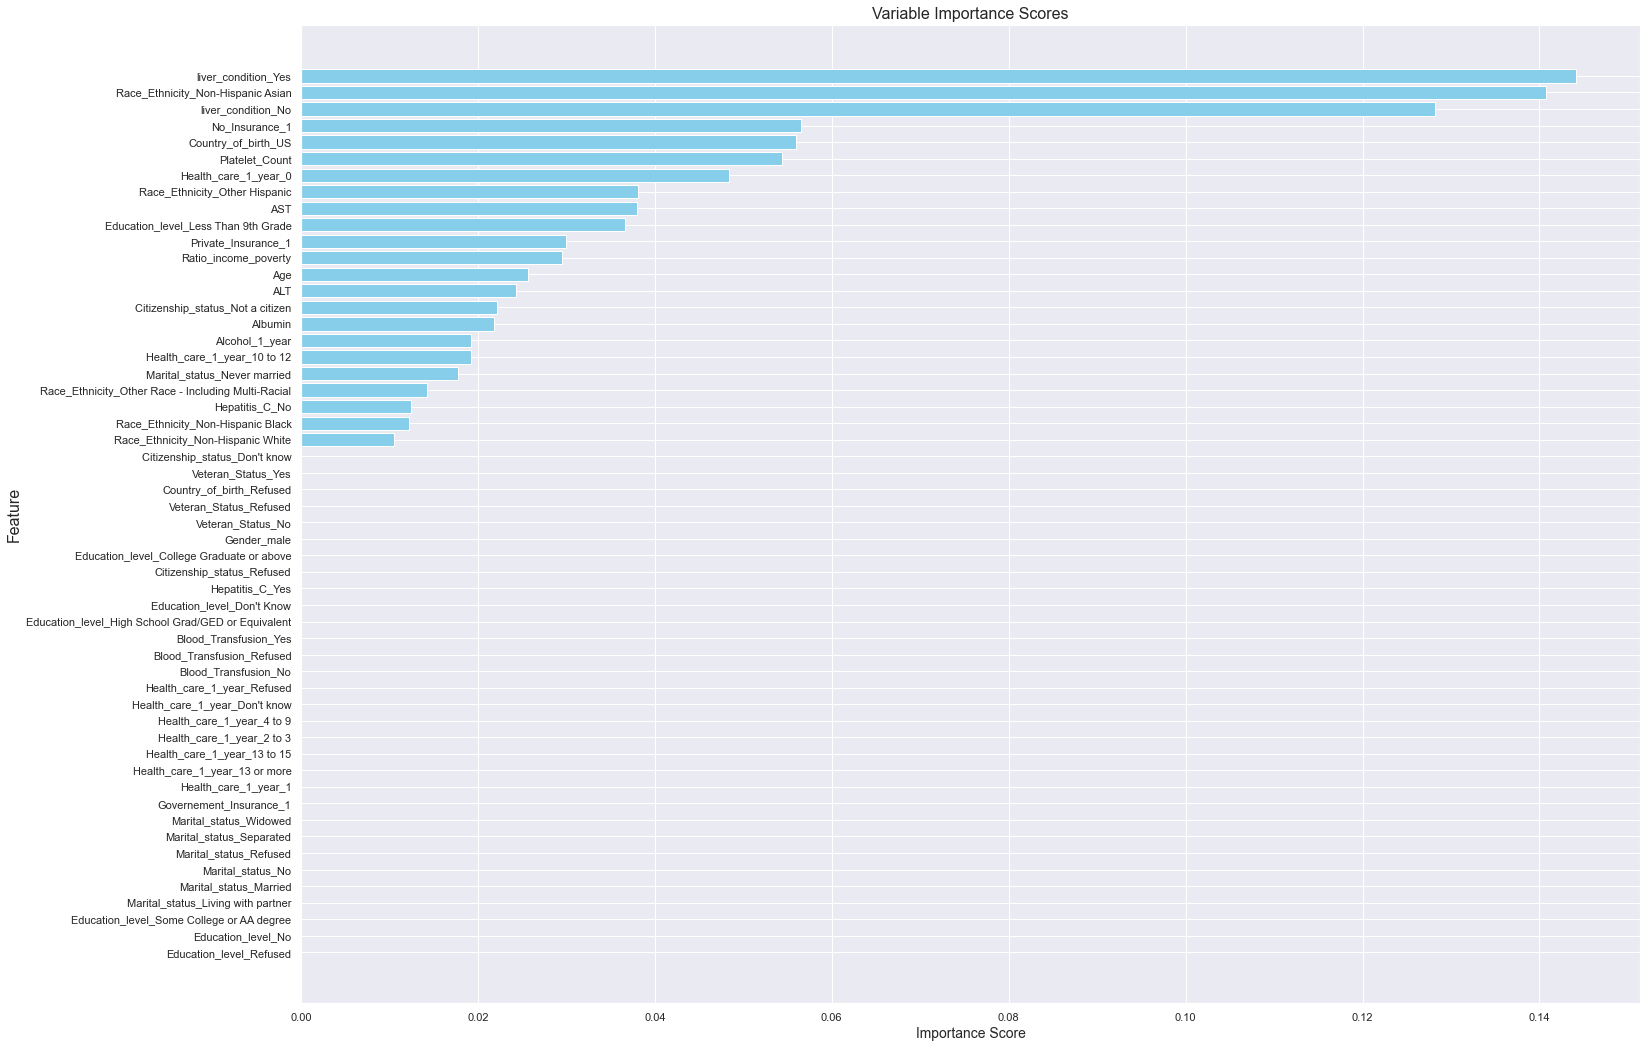

In [46]:
xgb_params = {
    'n_estimators': 50,
    'subsample': 0.9,
    'min_child_weight': 4,
    'max_depth': 3,
    'max_delta_step': 9,
    'learning_rate': 0.01,
    'gamma': 0.8,
    'colsample_bytree': 0.8
}
model_xgb = XGBClassifier(**xgb_params)

# Fit the model on the training data
model_xgb.fit(X_train, y_train)

# Get variable importance scores
importances = model_xgb.feature_importances_

# Get the names of the features
feature_names = X_train.columns

# Create a DataFrame with feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)  # Sorting in opposite order

# Plot the variable importance scores
plt.figure(figsize=(24, 18))  # Adjusting the plot size
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score', fontsize=14)  # Adjusting the text size
plt.ylabel('Feature', fontsize=16)  # Adjusting the text size
plt.title('Variable Importance Scores', fontsize=16)  # Adjusting the text size
plt.show()

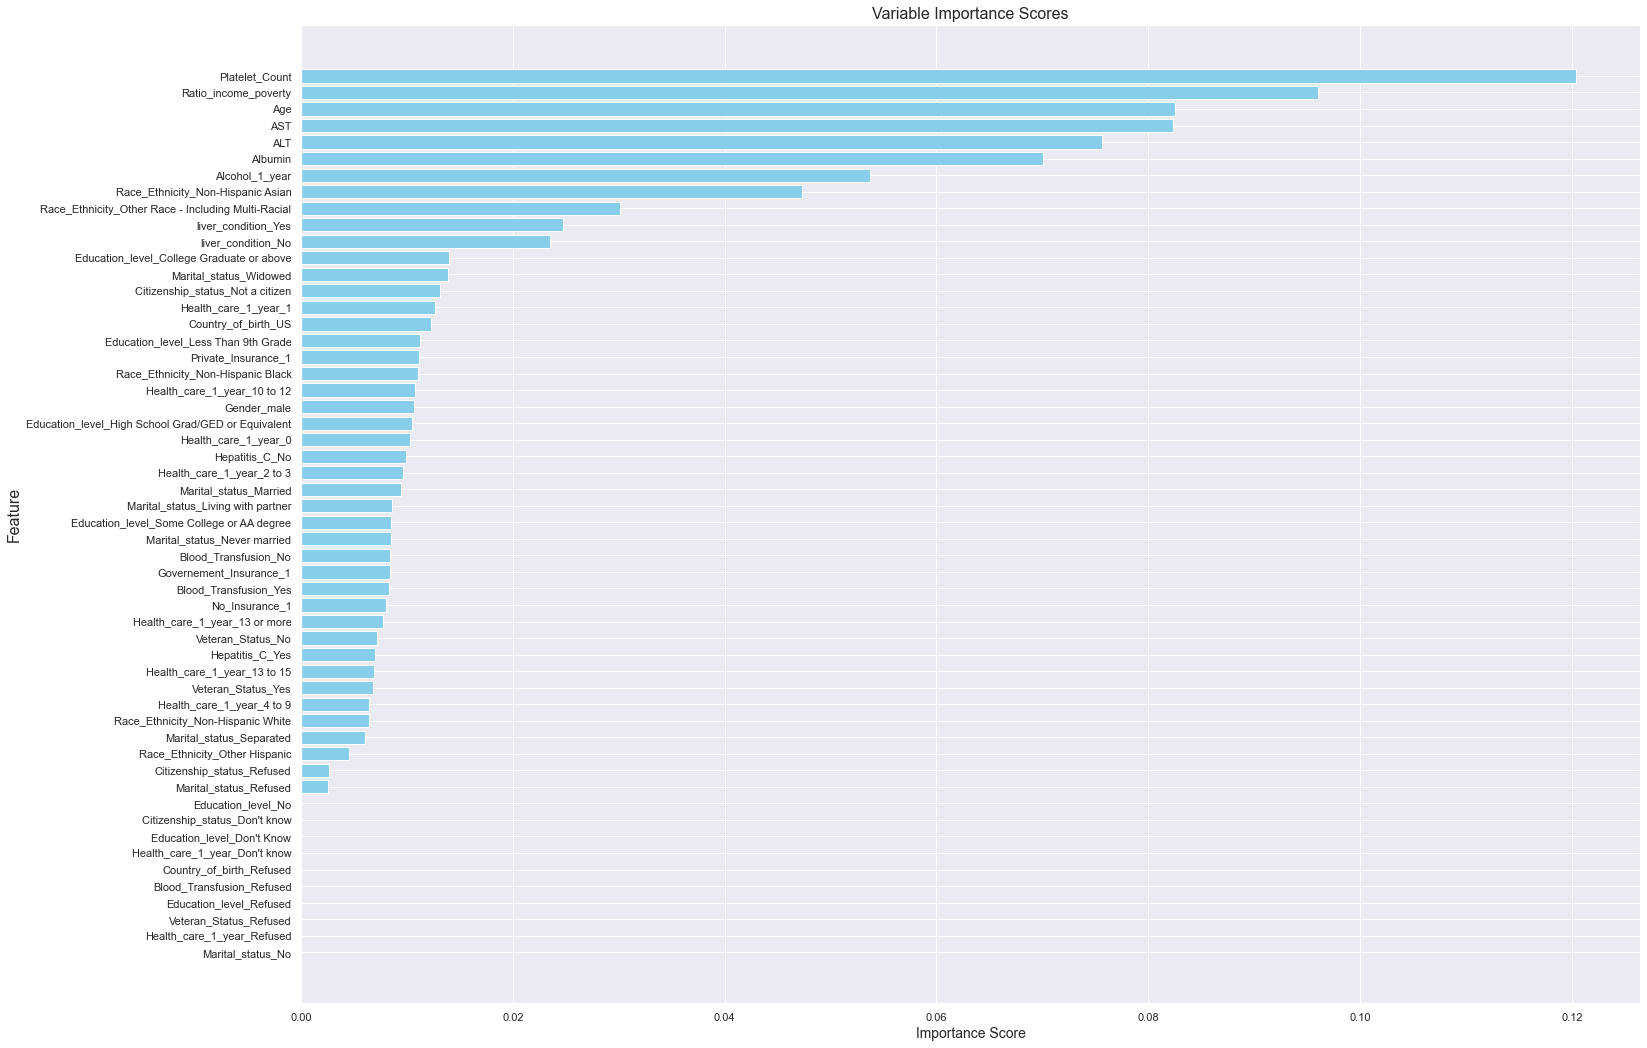

In [47]:
RdFo_params = {
    'n_estimators': 550,
    'min_samples_split': 10
}
model_rdfo = RandomForestClassifier(**RdFo_params)

# Fit the model on the training data
model_rdfo.fit(X_train, y_train)

# Get variable importance scores
importances = model_rdfo.feature_importances_

# Get the names of the features
feature_names = X_train.columns

# Create a DataFrame with feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)  # Sorting in opposite order

# Plot the variable importance scores
plt.figure(figsize=(24, 18))  # Adjusting the plot size
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score', fontsize=14)  # Adjusting the text size
plt.ylabel('Feature', fontsize=16)  # Adjusting the text size
plt.title('Variable Importance Scores', fontsize=16)  # Adjusting the text size
plt.show()